In [4]:
import numpy as np
import torch
from itertools import product
from scipy import stats

In [5]:
# Linear regression
num_samples = 100       # per group (total = num_samples * num_groups)
num_features = 700
num_groups = 3

np.random.seed(42)
noise_level = 0.1
true_beta = np.random.randn( num_features, 1 ) # does not include the identifier weight.

In [21]:
def fully_structured_covariance(d):
    return np.diag( np.random.uniform(0.3, 4, size = d) ** 2 )

def identity_covariance(d):
    return np.identity( d )

class Group:

    ID = 0

    def __init__(self, covariance_generator = lambda: identity_covariance(num_features) ):
        self.id = Group.ID + 1
        Group.ID += 1

        self.cov = covariance_generator()
        self.x_dist = stats.multivariate_normal( cov = self.cov )

        self.x = None
        self.y = None
    
    # Generates X (input vars) 
    def _generate_x(self, n_samples, ID = False , **kwargs):
        x = self.x_dist.rvs(size= n_samples, **kwargs)
        if ID:
            identifier = np.repeat( self.ID , repeats=n_samples)
            x = np.column_stack( (identifier, x))
        return x
    
    # Generates (X, y) pairs according to linear model
    def generate(self, n_samples, beta = true_beta):
        x = self._generate_x(num_samples)
        y = np.dot(x, beta) + noise_level * np.random.randn(num_samples, 1)
        self.data = [x, y]
    
    @property
    def data(self):
        return self.x, self.y
    
    @data.setter
    def data(self, value):
        x, y = value # unpack
        self.x = torch.tensor(x, dtype = torch.float32, requires_grad=False)
        self.y = torch.tensor(y, dtype = torch.float32, requires_grad=False)

# Create the data
cov_generator = lambda: fully_structured_covariance(num_features)
groups = [ Group(cov_generator) for _ in range(num_groups) ]

# TODO: by this data generating process, we have equal number of groups in the
# training data, all disjoint. should we change this up (vary # of samples/gp)?
Data = {}
for group in groups:
    group.generate(num_samples, beta= true_beta)

X = torch.cat( [ group.x for group in groups ], dim = 0 )
Y = torch.cat( [ group.y for group in groups ], dim = 0 )

In [86]:

class LinearModel(torch.nn.Module):

    def __init__(self, input_dimension, **kwargs) -> None:
        super(LinearModel, self).__init__()
        # Initialize at zero. 
        self.linear = torch.nn.Linear( input_dimension, 1, bias = False, **kwargs )
        self._initialize(0.0)
    
    @torch.no_grad()
    def _initialize(self, value):
        self.linear.weight.fill_(value)
        if self.linear.weight.grad is not None:
            self.linear.weight.grad.detach_()
            self.linear.weight.grad.zero_()
    
    # forward passes should NOT come from calling this directly!
    # i.e. model(x) instead of model.forward(x)
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # by default, MSELoss divides by n, the size of sample
    def risk(self, x, y):
        loss = torch.nn.MSELoss()
        mse = loss( self(x) , y )
        return mse
    
# training loop (gradient descent on the balanaced risk: lmbd * std + dro)
def optimize_GD(model, trade_regularization = 0.1, beta_regularization = 0, max_iter = 5000, lr = 1e-3, weight_decay = 0.0):
    lmbd = torch.tensor([trade_regularization], requires_grad=False)
    eta = torch.tensor([beta_regularization], requires_grad=False)  # explicit regularizer for beta
    optimizer = torch.optim.SGD( params = model.parameters(), lr = lr, weight_decay = weight_decay )

    flag = True         # for convergence criterion (objective low enough)
    iteration = 0
    while flag and iteration < max_iter:
        optimizer.zero_grad()

        standard_risk = model.risk( X, Y )
        adversarial_risk = torch.max( torch.stack( [ model.risk(group.x, group.y) for group in groups ] ) )
        objective = lmbd * standard_risk + adversarial_risk + eta * torch.norm(model.linear.weight)

        objective.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print(f" Objective loss is {objective.item():.4f}  = {lmbd.item():.2f} * { standard_risk.item():.4f} + {adversarial_risk.item():.4f}")
        iteration += 1

        # Check convergence
        if objective.item() < 1e-4:
            flag = False
    
    if iteration == max_iter:
        print("Maximum iteration reached.")

In [87]:
# Solve the weighted regression problem using vanilla GD
lmbd = torch.tensor([0.1], requires_grad=False)
max_iter = 2000

model = LinearModel(num_features)
optimize_GD(model, trade_regularization = 0.5, max_iter= max_iter)

 Objective loss is 6320.4780  = 0.50 * 3851.1809 + 4394.8877
 Objective loss is 64.1674  = 0.50 * 41.3549 + 43.4900
 Objective loss is 11.5422  = 0.50 * 7.5086 + 7.7879
 Objective loss is 3.1426  = 0.50 * 2.0018 + 2.1417
 Objective loss is 0.9565  = 0.50 * 0.6219 + 0.6456
 Objective loss is 0.3278  = 0.50 * 0.2087 + 0.2235
 Objective loss is 0.1149  = 0.50 * 0.0735 + 0.0781
 Objective loss is 0.0413  = 0.50 * 0.0268 + 0.0279
 Objective loss is 0.0155  = 0.50 * 0.0100 + 0.0105
 Objective loss is 0.0058  = 0.50 * 0.0038 + 0.0039
 Objective loss is 0.0022  = 0.50 * 0.0015 + 0.0015
 Objective loss is 0.0009  = 0.50 * 0.0006 + 0.0006
 Objective loss is 0.0003  = 0.50 * 0.0002 + 0.0002
 Objective loss is 0.0001  = 0.50 * 0.0001 + 0.0001


In [88]:
# OLS
ols_beta = torch.linalg.lstsq( X, Y ).solution

# Subgroups- OLS
subgroup_beta = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ]

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

betas = np.hstack( [model.linear.weight.data.numpy().T, ols_beta.data.numpy()] + [beta.data.numpy() for beta in subgroup_beta ] )
betas = pd.DataFrame( betas, columns=["model", "OLS"] + [f"Group {i} OLS" for i in range(num_groups)] )

In [90]:
betas.corr()

,model,OLS,Group 0 OLS,Group 1 OLS,Group 2 OLS
model,1.000000,1.000000,0.546721,0.619180,0.528948
OLS,1.000000,1.000000,0.546681,0.619126,0.528920
Group 0 OLS,0.546721,0.546681,1.000000,0.150638,0.111400
Group 1 OLS,0.619180,0.619126,0.150638,1.000000,0.134142
Group 2 OLS,0.528948,0.528920,0.111400,0.134142,1.000000


## Experiment 1: Varying $\lambda$ Tradeoff Parameter
Our notion of tradeoff risk between DRO and standard risk is controlled by the parameter $\lambda$. Fully writing out the
tradeoff objective, we have:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) := \mathcal{R}_{\mathrm{group}}(\beta) + \lambda \mathcal{R}_{\mathrm{std}}(\beta)
= \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right],
$$
where $\mathbb{P}_g$ is the group distribution for group $g \in \mathcal{G}$. The $\lambda$ parameter controls how much we tradeoff for standard risk in our objective. $\lambda = 0$ means we are solely optimizing for group DRO. We vary the value of $\lambda$ and see if this has any effect on the resulting $\hat{\beta}$ that our model produces by minimizing $\hat{\mathcal{R}}_{\mathrm{trade}}$


In [91]:
import matplotlib.pyplot as plt

max_iter = 2000
lambdas = torch.tensor(np.linspace(0, 10.0), requires_grad=False)
ols_beta = torch.linalg.lstsq( X, Y ).solution  # regular OLS solution
subgroup_betas = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ] # OLS for each group
model_betas = list()

for lmbd in lambdas:
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, trade_regularization = lmbd, max_iter= max_iter)
    model_betas.append(model.linear.weight.data.numpy().T)

 Objective loss is 4394.8877  = 0.00 * 3851.1809 + 4394.8877
 Objective loss is 99.4866  = 0.00 * 94.0577 + 99.4866
 Objective loss is 22.4200  = 0.00 * 21.2680 + 22.4200
 Objective loss is 7.7334  = 0.00 * 7.3495 + 7.7334
 Objective loss is 3.1883  = 0.00 * 2.9754 + 3.1883
 Objective loss is 1.3494  = 0.00 * 1.3091 + 1.3494
 Objective loss is 0.6196  = 0.00 * 0.6028 + 0.6196
 Objective loss is 0.2995  = 0.00 * 0.2889 + 0.2995
 Objective loss is 0.1443  = 0.00 * 0.1413 + 0.1443
 Objective loss is 0.0732  = 0.00 * 0.0706 + 0.0732
 Objective loss is 0.0389  = 0.00 * 0.0357 + 0.0389
 Objective loss is 0.0196  = 0.00 * 0.0183 + 0.0196
 Objective loss is 0.0095  = 0.00 * 0.0095 + 0.0095
 Objective loss is 0.0051  = 0.00 * 0.0049 + 0.0051
 Objective loss is 0.0027  = 0.00 * 0.0026 + 0.0027
 Objective loss is 0.0014  = 0.00 * 0.0014 + 0.0014
 Objective loss is 0.0008  = 0.00 * 0.0007 + 0.0008
 Objective loss is 0.0004  = 0.00 * 0.0004 + 0.0004
 Objective loss is 0.0002  = 0.00 * 0.0002 + 0.00

Text(0, 0.5, '$\\| \\beta_{\\mathrm{trade}} - \\beta_{\\mathrm{OLS}} \\|_2$')

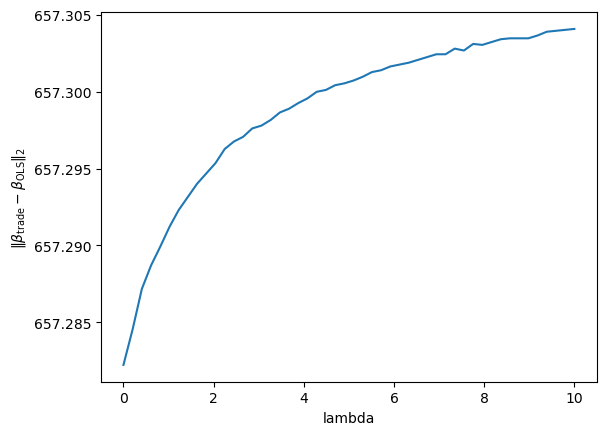

In [92]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy().T) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xlabel("lambda")
plt.ylabel(r'$\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2$')

## Experiment 2: Adding Explicit Regularizer and Varying $\lambda$ Tradeoff Parameter
Now, we add an explicit $\ell_2$ regularization to the objective, controlled by $\eta > 0.$ This gives us the objective:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) + \eta \|\beta\|_2
= \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right] + \eta\|\beta\|_2.
$$
Again, we first look at the effect that varying $\lambda$ has on this objective.

In [95]:
import matplotlib.pyplot as plt

max_iter = 2000
lambdas = torch.tensor(np.linspace(0, 10.0), requires_grad=False)
ols_beta = torch.linalg.lstsq( X, Y ).solution  # regular OLS solution (TODO: regularize this)
subgroup_betas = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ] # OLS for each group
model_betas = list()

# Fix beta regularizer to 0.1, vary lambdas
for lmbd in lambdas:
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, trade_regularization = lmbd, beta_regularization=0.1, max_iter= max_iter)
    model_betas.append(model.linear.weight.data.numpy().T)

 Objective loss is 4394.8877  = 0.00 * 3851.1809 + 4394.8877
 Objective loss is 101.1026  = 0.00 * 94.1922 + 99.6609
 Objective loss is 24.1462  = 0.00 * 21.3383 + 22.5286
 Objective loss is 9.4619  = 0.00 * 7.3925 + 7.7818
 Objective loss is 4.9382  = 0.00 * 3.0047 + 3.2281
 Objective loss is 3.1003  = 0.00 * 1.3300 + 1.3731
 Objective loss is 2.3647  = 0.00 * 0.6172 + 0.6273
 Objective loss is 2.0625  = 0.00 * 0.2982 + 0.3186
 Objective loss is 1.8994  = 0.00 * 0.1487 + 0.1514
 Objective loss is 1.8285  = 0.00 * 0.0758 + 0.0778
 Objective loss is 1.7935  = 0.00 * 0.0396 + 0.0409
 Objective loss is 1.7758  = 0.00 * 0.0211 + 0.0220
 Objective loss is 1.7670  = 0.00 * 0.0116 + 0.0124
 Objective loss is 1.7621  = 0.00 * 0.0065 + 0.0069
 Objective loss is 1.7598  = 0.00 * 0.0038 + 0.0042
 Objective loss is 1.7583  = 0.00 * 0.0024 + 0.0025
 Objective loss is 1.7577  = 0.00 * 0.0015 + 0.0016
 Objective loss is 1.7574  = 0.00 * 0.0011 + 0.0011
 Objective loss is 1.7572  = 0.00 * 0.0008 + 0.0

In [ ]:
# TODO: do standard OLS with regularization to compare?